This notebook is provided as part of the 2MRSxCMB repository. It contains code to perform calculations from Addison (2024), <i>Does the Correlation between 2MRS Galaxies and the CMB Indicate an Unmodeled CMB Foreground?</i>

The paper is accepted for publication by the Astrophysical Journal and is also available on arXiv at https://arxiv.org/abs/2403.10490.

The code blocks below do the following:

(1) Read in the 2MRS catalog (a copy is provided in the data/ directory, obtained from the 2MRS website http://tdc-www.cfa.harvard.edu/2mrs/) and the Planck SMICA CMB map and mask (available from the Planck Legacy Archive http://pla.esac.esa.int/pla/#maps, click Maps -> CMB maps -> SMICA -> FULL MISSION).

(2) Compute the $\Delta T(\theta)$ correlation statistic (equation 1 of the paper) between a CMB map and a catalog.

(3) Create simulated CMB maps and correlate them with the 2MRS catalogs, as described in section 3 of the paper.

(4) Estimate the $\Delta T(\theta)$ covariance matrix (between different angular bins) and compute a $\chi^2$ statistic for the real and simulated maps, against the null hypothesis of zero correlation.

Please direct any questions to Graeme Addison (gaddison@jhu.edu).

Import statements

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import astropy
import astropy.io.fits
import healpy as hp
import timeit

Load the 2MRS catalog, CMB map, and mask.

In [2]:
catalog = astropy.io.fits.open('data/2mrs_1175_done.fits')
smica_map = hp.read_map('data/COM_CMB_IQU-smica_2048_R3.00_full.fits', field=0)
smica_mask = hp.read_map('data/COM_CMB_IQU-smica_2048_R3.00_full.fits', field=3)

Load theory CMB temperature power spectrum used for generating simulated CMB maps. The spectrum in the file provided was computed using the Planck 2018 best-fit $\Lambda$CDM parameters from the temperature, polarization, and lensing power spectra.

In [3]:
cl_input_cmb = np.genfromtxt('data/dl_cmb_theory_pycamb_plikHM_TTTEEE_lowl_lowE_lensing_lmax3508.txt')[:3509]

## Convert from D_ell to C_ell
cl_input_cmb[2:3509] *= 2 * np.pi / np.arange(2, 3509) / np.arange(3, 3510)

Define functions to perform $\Delta T(\theta)$ calculation (equation 1 of the paper).

In [4]:
## This function computes \Delta T for each galaxy as a function of radius using healpy.query_disc

def get_deltaT_npix(catalog_lon, catalog_lat, theta, sky_map, sky_mask, inclusive=True, submono=False):
    
    if len(catalog_lon) != len(catalog_lat):
        print("Mismatched lon/lat input!")
        return -1
    
    ## Simple monopole estimate and subtraction
    if submono == True:
        sky_map -= np.mean(sky_map * sky_mask) / np.mean(sky_mask)
    
    ngal = len(catalog_lon)
    ntheta_deltaT = len(theta)
    
    ## Keep track of how many pixels as a function of radius fall outside sky mask
    npix = np.zeros([ngal, ntheta])
    
    deltaTgal = np.zeros([ntheta, ngal])
    
    for i in range(ntheta):
        for j in range(ngal):
            ## Return indices of HEALPix pixels within ring of radius theta[i] from galaxy j
            ipix = hp.query_disc(nside, hp.ang2vec(catalog_lon[j], catalog_lat[j], lonlat=True), theta[i], inclusive=inclusive)
            npix[j, i] += np.sum(sky_mask[ipix])
            deltaTgal[i, j] += np.sum(sky_map[ipix] * sky_mask[ipix])
    
    return deltaTgal, npix


## This function computes the mean and standard deviation in \delta T(\theta) across the galaxy sample in annuli by 
## differencing results for  successive radii computed from get_deltaT_npix, above.

def get_deltaT_mean_std_neff(deltaTgal, npix, theta):
    ntheta_deltaT = len(theta)
    
    deltaTgal_annulus = deltaTgal[1:] - deltaTgal[:-1]
    npix_annulus = (npix[:, 1:] - npix[:, :-1]).T
    
    deltaT_mean = np.zeros(ntheta_deltaT-1)
    deltaT_std = np.zeros(ntheta_deltaT-1)
    ngal_eff = np.zeros(ntheta_deltaT-1)
    
    for i in range(ntheta_deltaT-1):
        
        ## Only select galaxies with >0 valid (unmasked) pixels in this annulus
        npix_annulus_i = npix_annulus[i]
        nonzero_i = np.where(npix_annulus_i > 0)
        
        deltaT_annulus_i = deltaTgal_annulus[i, nonzero_i]
        npix_annulus_i = npix_annulus_i[nonzero_i]
        
        ngal_eff[i] = len(nonzero_i[0])
        
        deltaT_mean[i] = np.mean(deltaT_annulus_i / npix_annulus_i)
        deltaT_std[i] = np.std(deltaT_annulus_i / npix_annulus_i)
    
    return deltaT_mean, deltaT_std, ngal_eff

Define HEALPix map resolution and angular bins

In [5]:
nside = 2048

## This defines boundaries of annuli. For ntheta = 20 boundaries there are 20 - 1 = 19 angular bins
ntheta = 20

## Logarithmically-spaced bins from 0.01 to ~20 degrees. Convert to radians.
radius_log = np.logspace(-2, 1.3, ntheta) * np.pi / 180

Select 2MRS galaxy sample based on redshift, morphology type, and/or other catalog fields. See 2MRS readme for more information on the catalog fields including morphological type classification: http://tdc-www.cfa.harvard.edu/2mrs/2mrs_readme.html.

In [6]:
## Elliptical galaxies, 300<cz<4500, E class (type classification -5)
galaxy_sample = np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == '-5'))[0]

## Late-type spiral galaxies, 300<cz<4500, Sb/Sc/Sd class (type classification 3, 4, 5, 6, 7, and 8)
# galaxy_sample = np.concatenate((np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 3'))[0], np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 4'))[0], np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 5'))[0], np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 6'))[0], np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 7'))[0], np.where((catalog[1].data['V']>300) & (catalog[1].data['V']<4500) & (catalog[1].data['TYPE'].astype('U2') == ' 8'))[0]))

Compute $\Delta T(\theta)$ for galaxy sample and CMB data map

In [7]:
start_time = timeit.default_timer()
deltaTgal, npix = get_deltaT_npix(catalog[1].data['GLON'][galaxy_sample], catalog[1].data['GLAT'][galaxy_sample], radius_log, smica_map, smica_mask)
deltaT_mean, deltaT_std, deltaT_neff = get_deltaT_mean_std_neff(deltaTgal, npix, radius_log)
finish_time = timeit.default_timer()
print('Time taken ', finish_time - start_time)

Time taken  10.736446583999996


Compute $\Delta T(\theta)$ for galaxy sample and simulated CMB maps. Note that 1000 simulation realizations were used for the results shown in the paper (Figure 2). Depending on the size of the galaxy sample this can take many hours to evaluate. The default here is just to run 10 realizations. Results from the full set of 1000 simulations are provided for the elliptical and spiral samples as .npy files in the data/ directory (see below).

In [8]:
#nsim = 1000
nsim = 10

deltaT_mean_simcmb = np.zeros([nsim, ntheta-1])
deltaT_std_simcmb = np.zeros([nsim, ntheta-1])
deltaT_neff_simcmb = np.zeros([nsim, ntheta-1])

## Fix the random number seed for reproducibility
np.random.seed(999)

## 5' FWHM beam to match SMICA processing
beam = hp.gauss_beam(fwhm=np.pi/180/12, lmax=3508)

start_time = timeit.default_timer()

for i in range(nsim):
    print(i)
    
    ## Generate random CMB map. Include extra (white) small-scale power, see Section 3 of the paper
    ## Convert to K for consistency with SMICA map units
    map_cmb_sim = 1e-6 * hp.synfast(cl_input_cmb * beam**2 + 1.5e-4, nside=nside)
    
    deltaTgal_temp, npix_temp = get_deltaT_npix(catalog[1].data['GLON'][galaxy_sample], catalog[1].data['GLAT'][galaxy_sample], radius_log, map_cmb_sim, smica_mask)  # , _submono=True)
    deltaT_mean_simcmb[i], deltaT_std_simcmb[i], deltaT_neff_simcmb[i] = get_deltaT_mean_std_neff(deltaTgal_temp, npix_temp, radius_log)

finish_time = timeit.default_timer()
print('Time taken ', finish_time - start_time)

0
1
2
3
4
5
6
7
8
9
Time taken  144.704958459


Load $\Delta T(\theta)$ results for all 1000 CMB simulations. Results for both the elliptical and spiral galaxy samples at $300<cz<4500$ are provided in the data/ directory.

In [8]:
nsim = 1000
deltaT_mean_simcmb = np.load('data/deltaT_mean_z_300_4500_E_simcmb_fwhm5arcmin_white1p5em4_nsim1000.npy')
#deltaT_mean_simcmb = np.load('data/deltaT_mean_z_300_4500_SbScSd_simcmb_fwhm5arcmin_white1p5em4_nsim1000.npy.npy')

Plot the $\Delta T(\theta)$ results for the real CMB map and simulations, as in Figure 2 of the paper.

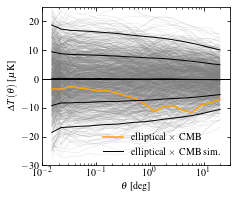

In [10]:
fig = plt.figure(figsize=(3.25, 2.5))

fig.subplots_adjust(left=0.18, right=0.98, top=0.98, hspace=0, bottom=0.1)

ax = fig.add_subplot(111)

for i in range(nsim):
    plt.plot(180 / np.pi * radius_log[1:], 1e6 * deltaT_mean_simcmb[i], lw=0.1, c='gray')

plt.plot(180 / np.pi * radius_log[1:], 1e6 * deltaT_mean, c='orange', label=r'elliptical $\times$ CMB', lw=1.5)  #, alpha=0.1*(i+1))

plt.plot(180 / np.pi * radius_log[1:], 1e6 * np.mean(deltaT_mean_simcmb, axis=0), label=r'elliptical $\times$ CMB sim.', lw=1, c='k')
plt.plot(180 / np.pi * radius_log[1:], 1e6 * (np.mean(deltaT_mean_simcmb, axis=0) + np.std(deltaT_mean_simcmb, axis=0)), lw=1, c='k')
plt.plot(180 / np.pi * radius_log[1:], 1e6 * (np.mean(deltaT_mean_simcmb, axis=0) - np.std(deltaT_mean_simcmb, axis=0)), lw=1, c='k')
plt.plot(180 / np.pi * radius_log[1:], 1e6 * (np.mean(deltaT_mean_simcmb, axis=0) + 2 * np.std(deltaT_mean_simcmb, axis=0)), lw=1, c='k')
plt.plot(180 / np.pi * radius_log[1:], 1e6 * (np.mean(deltaT_mean_simcmb, axis=0) - 2 * np.std(deltaT_mean_simcmb, axis=0)), lw=1, c='k')

plt.xscale('log')
plt.axhline(0, c='k', lw=1)
plt.xlim([0.01, 30])

plt.ylim([-30, 25])

ax.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$\Delta T(\theta)$ [$\mu$K]')

plt.legend(frameon=False, ncol=1, fontsize=10)

plt.show()

Estimate the $\Delta T(\theta)$ covariance matrix using the simulations, then compute a $\chi^2$ statistic for each realization plus the real CMB map. See Section 3 and Table 1 of the paper.

In [11]:
cov = np.cov(deltaT_mean_simcmb.T)

## Restrict \theta range to reproduce values in Table 1; bmin = 6 corresponds to excluding scales below 0.1 degree

bmin, bmax = 6, 19

## Compute inverse covariance based on the subset of \theta bins we want to use

icov = np.linalg.inv(cov[bmin:bmax][:, bmin:bmax])

chi2_sim = np.diag(np.dot(deltaT_mean_simcmb[:, bmin:bmax], np.dot(icov, deltaT_mean_simcmb[:, bmin:bmax].T)))
chi2_data = np.dot(deltaT_mean[bmin:bmax], np.dot(icov, deltaT_mean[bmin:bmax]))

## Estimate PTE (probability to exceed) based on how many simulation realizations have higher \chi^2

pte = np.sum(chi2_sim > chi2_data) / nsim

## Equivalent Gaussian "N\sigma"

gaussian_nsigma = sp.stats.norm.isf(pte)

print('PTE: ', pte)
print('Equivalent Gaussian N-sigma: ', gaussian_nsigma)

PTE:  0.434
Equivalent Gaussian N-sigma:  0.16619944017035887
